In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
from denoising_diffusion_pytorch import Unet1D, GaussianDiffusion1D, Trainer1D, Dataset1D

seed = 42

torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Choice number of Gaussians + Standard DDPM

In [2]:
num_gaussians = 2
means = torch.tensor([0.35, 0.65])
stds = torch.tensor([0.1, 0.1])

num_points = 50000
mode = "sampling"
num_epochs = 10000
std_data = 0.5

In [3]:
def gauss_train_dataset(num_gaussians, num_points):

    training_data = []

    for i in range(num_gaussians):
        single_gauss_shape = num_points // num_gaussians
        single_gauss = torch.normal(means[i], stds[i], (single_gauss_shape,))
        training_data.append(single_gauss)
    stacked_data = torch.cat(training_data)
    return stacked_data.unsqueeze(-1).unsqueeze(-1)

def plot_dataset(training_seq, title):
    
    hist = plt.hist(training_seq[:,0], bins = 50)
    plt.xlim(0,1)
    plt.title(title)

Shape:  torch.Size([50000, 1, 1])


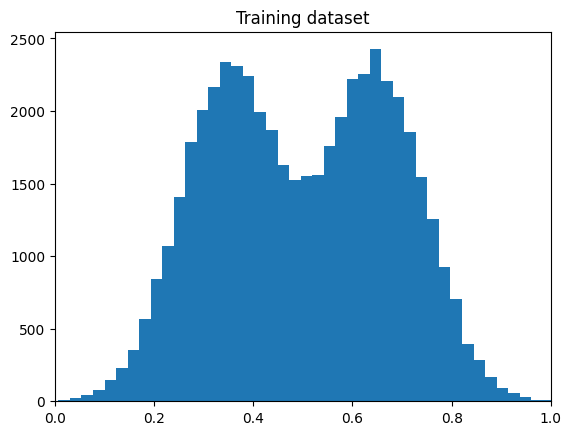

In [4]:
training_seq = gauss_train_dataset(num_gaussians, num_points)
print("Shape: ", training_seq.shape)
plot_dataset(training_seq, "Training dataset")

In [5]:
model = Unet1D(
    dim = 64,
    dim_mults = (1, ),
    channels = 1
)

diffusion = GaussianDiffusion1D(
    model,
    seq_length = 1,
    timesteps = 1000,
    objective = 'pred_v'
)

# Using trainer

dataset = Dataset1D(training_seq)  # this is just an example, but you can formulate your own Dataset and pass it into the `Trainer1D` below

trainer = Trainer1D(
    diffusion,
    dataset = dataset,
    train_batch_size = 32,
    train_lr = 8e-5,
    train_num_steps = num_epochs,         # total training steps
    save_and_sample_every = 100000, # gets saved to "results" folder (disable with high save_and_sample_every)
    gradient_accumulate_every = 2,    # gradient accumulation steps
    ema_decay = 0.995,                # exponential moving average decay
    amp = True,                       # turn on mixed precision
)

if mode == "continuing":
    state_dict = torch.load(f"model_checkpoints/{num_gaussians}D_gauss_6000.pt", map_location="cpu")
    model.load_state_dict(state_dict)

    trainer.train()

    torch.save(
        model.state_dict(),
        f"model_checkpoints/{num_gaussians}D_gauss_8000.pt"
    ) 

if mode == "training":
    trainer.train()

    torch.save(
        model.state_dict(),
        f"model_checkpoints/{num_gaussians}D_gauss_{num_epochs}_{std_data}.pt"
    ) 

if mode == "sampling":
    state_dict = torch.load(f"model_checkpoints/2D_gauss_overlap.pt", map_location="cpu")
    model.load_state_dict(state_dict)


Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


/n/home00/zoewu/.conda/envs/parallel_toy/lib/python3.10/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 64 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# Plot for measuring effect of changing k, kcns, and tau

In [6]:
# k_list = [0.25, 1.0, 4.0, 8.0]
# k_cns_list = [0.25, 1.0, 4.0, 8.0]
# chunks_list = [1, 2, 4, 8]

# fixed_k = 1.0
# fixed_k_cns = 1.0
# fixed_tau = 0.0

# fixed_n_chunks = 1
# riemann_tau = 0.5

# fig, axes = plt.subplots(
#     nrows=3,
#     ncols=1 + len(k_list),
#     figsize=(4 * (1 + len(k_list)), 9),
#     sharex=True,
#     sharey=True
# )

# # -------------------------------------------------
# # Column 0: training data (all rows)
# # -------------------------------------------------
# training_np = training_seq.detach().cpu().numpy()

# row_labels = ["vary k", "vary k_cns", "k & k_cns"]

# for i in range(3):
#     ax = axes[i, 0]
#     ax.hist(training_np[:, 0], bins=100)
#     ax.axvline(means[0], color = "orange")
#     ax.axvline(means[1], color = "orange")
#     ax.set_xlim(0, 1)
#     ax.set_ylabel(row_labels[i])

# axes[0, 0].set_title("Training data")

# # -------------------------------------------------
# # Row 0: vary k (k_cns fixed)
# # -------------------------------------------------
# for j, k in enumerate(k_list):
#     ax = axes[0, j + 1]

#     sampled_seq = diffusion.sample(
#         k=k,
#         k_cns=fixed_k_cns,
#         tau=fixed_tau,
#         n_chunks = fixed_n_chunks,
#         batch_size=num_points
#     )
#     mask = ((sampled_seq >= 0.05) & (sampled_seq <= 0.95)).all(dim=1)
#     sampled_seq = sampled_seq[mask]
#     sampled_np = sampled_seq.detach().cpu().numpy()

#     ax.hist(sampled_np[:, 0], bins=100)
#     ax.axvline(means[0], color = "orange")
#     ax.axvline(means[1], color = "orange")
#     ax.set_xlim(0, 1)
#     ax.set_title(f"k = {k}")

# # -------------------------------------------------
# # Row 1: vary k_cns (k fixed)
# # -------------------------------------------------
# for j, k_cns in enumerate(k_cns_list):
#     ax = axes[1, j + 1]

#     sampled_seq = diffusion.sample(
#         k=fixed_k,
#         k_cns=k_cns,        
#         tau=fixed_tau,
#         n_chunks=fixed_n_chunks,
#         batch_size=num_points
#     )
#     mask = ((sampled_seq >= 0.05) & (sampled_seq <= 0.95)).all(dim=1)
#     sampled_seq = sampled_seq[mask]
#     sampled_np = sampled_seq.detach().cpu().numpy()

#     ax.hist(sampled_np[:, 0], bins=100)
#     ax.axvline(means[0], color = "orange")
#     ax.axvline(means[1], color = "orange")
#     ax.set_xlim(0, 1)
#     ax.set_title(f"k_cns = {k_cns}")

# # # -------------------------------------------------
# # # Row 2: vary k and k_cns together
# # # -------------------------------------------------
# # k_cns_constant = 0.5
# # for j, (k, k_cns) in enumerate(zip(k_list, k_cns_list)):
# #     k_cns = k_cns_constant
# #     ax = axes[2, j + 1]

# #     sampled_seq = diffusion.sample(
# #         k=k,
# #         k_cns=k_cns,
# #         batch_size=num_points
# #     )
# #     mask = ((sampled_seq >= 0.05) & (sampled_seq <= 0.95)).all(dim=1)
# #     sampled_seq = sampled_seq[mask]

# #     sampled_np = sampled_seq.detach().cpu().numpy()

# #     ax.hist(sampled_np[:, 0], bins=100)
# #     ax.set_xlim(0, 1)
# #     ax.set_title(f"k={k}, k_cns={k_cns}")

# # -------------------------------------------------
# # Row 3: vary tau
# # -------------------------------------------------
# for j, n_chunks in enumerate(chunks_list):
#     ax = axes[2, j + 1]

#     sampled_seq = diffusion.sample(
#         k=fixed_k,
#         k_cns=fixed_k_cns,
#         tau=riemann_tau,
#         n_chunks=n_chunks,
#         batch_size=num_points
#     )
#     mask = ((sampled_seq >= 0.05) & (sampled_seq <= 0.95)).all(dim=1)
#     sampled_seq = sampled_seq[mask]
#     sampled_np = sampled_seq.detach().cpu().numpy()

#     ax.hist(sampled_np[:, 0], bins=100)
#     ax.axvline(means[0], color = "orange")
#     ax.axvline(means[1], color = "orange")
#     ax.set_xlim(0, 1)
#     ax.set_title(f"n_chunbks = {n_chunks}")

# plt.tight_layout()
# plt.show()

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

1.527186396332628
3.786643600876827
6.471459528024031
15.111209910151574
76.43432358669243
288.7854395601816
28.73041212913652
9.934161289247609
5.136570109505965
1.6307877964502877
0.7727767268394963
3.8087881597233144
6.469841007718208
15.190286650244355
76.63177942166584
286.0929533506228
28.630267781397716
9.886544987864704
5.162342090576903
0.7732847086444694
0.7888319514209539
3.790980844623051
6.384471830480381
14.775629444999103
76.30682011133449
300.1825028334757
28.105545670542714
9.932146299748585
5.185618267310176
0.7920419428296679
0.8012003900029707
3.7416485631195484
6.328663689998943
14.502599840728632
69.55403634623724
314.5092091951215
28.777324493711077
10.25512178369016
5.2969362406573985
0.805055046856141
0.8144713325034134
3.646318251507397
6.095691428021568
13.811828005648348
64.85184638603127
308.57421992305126
30.01785468575993
10.167140425889
5.2403571777945235
0.8189283655130203
0.8271199404325655
3.4880981699271842
5.842421618367267
13.156909902419878
63.445

(0.0, 2500.0)

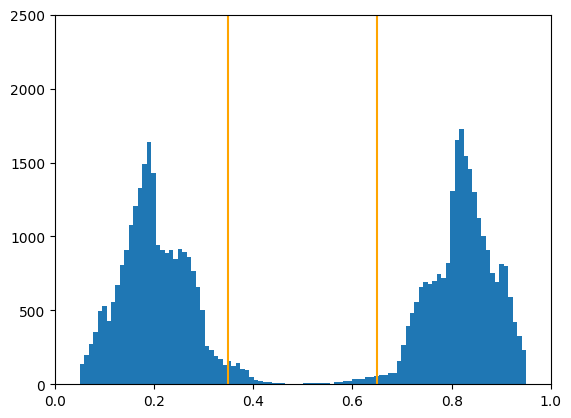

In [10]:
sampled_seq = diffusion.sample(
    k = 1.0,
    k_cns = 1.0,
    tau = 0.25,
    n_chunks = 10,
    batch_size=num_points
)

mask = ((sampled_seq >= 0.05) & (sampled_seq <= 0.95)).all(dim=1)
sampled_seq = sampled_seq[mask]
sampled_np = sampled_seq.detach().cpu().numpy()
_ = plt.hist(sampled_np[:, 0], bins=100)
plt.axvline(means[0], color = "orange")
plt.axvline(means[1], color = "orange")
plt.xlim(0,1)
plt.ylim(0,2500)

In [ ]:
sampled_seq = diffusion.sample(
    k = 1.0,
    k_cns = 1.0,
    tau = 0.0,
    n_chunks = 1,
    batch_size=num_points
)

mask = ((sampled_seq >= 0.05) & (sampled_seq <= 0.95)).all(dim=1)
sampled_seq = sampled_seq[mask]
sampled_np = sampled_seq.detach().cpu().numpy()
_ = plt.hist(sampled_np[:, 0], bins=100)
plt.axvline(means[0], color = "orange")
plt.axvline(means[1], color = "orange")
plt.xlim(0,1)
plt.ylim(0,2500)

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


KeyboardInterrupt: 